In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from   scipy.stats import t as t_dist
from   scipy.special import logsumexp

In [45]:
t.logpdf(np.array([i for i in range(10)]),1,1,1)

array([-1.83787707, -1.14472989, -1.83787707, -2.7541678 , -3.44731498,
       -3.97794323, -4.40282642, -4.7556478 , -5.05675289, -5.31911716])

In [54]:

class GaussianUnknownVar:
    
    def __init__(self, a0, b0):
        
        self.a0 = a0
        self.b0  = b0
        self.a_params = np.array([a0])
        self.b_params = np.array([b0])
    
    def log_pred_prob(self, t, x):
        """Compute predictive probabilities \pi, i.e. the posterior predictive
        for each run length hypothesis.
        """
        # Posterior predictive:
        post_a = self.a_params[:t]
        post_b  = self.b_params[:t]
        return t_dist.logpdf(x,df = 2 * post_a,loc = 0,scale = post_b/post_a)
    
    def update_params(self, t, x):
        """Upon observing a new datum x at time t, update all run length 
        hypotheses.
        """
        
        new_b_params  = self.b_params + (x ** 2)/2
        self.b_params = np.append([self.b0], new_b_params)
        
        new_a_params  = self.a_params + (1/2)
        self.mean_params = np.append([self.a0], new_a_params)



<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
C:\Users\a2839\AppData\Local\Temp\ipykernel_25920\3819639679.py:16: SyntaxWarning: invalid escape sequence '\p'
  """Compute predictive probabilities \pi, i.e. the posterior predictive


In [81]:
# get stock data
df = pd.read_csv(r"C:\Users\a2839\OneDrive\文档\CATAM\1.2 ODE\Applie_stock.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,12/12/1996,0.215402,0.216518,0.213170,0.213170,0.180470,87001600
1,12/13/1996,0.212054,0.213170,0.207589,0.207589,0.175745,89096000
2,12/16/1996,0.209821,0.209821,0.200893,0.202009,0.171021,149240000
3,12/17/1996,0.199777,0.200893,0.198661,0.200893,0.170076,157248000
4,12/18/1996,0.203125,0.206473,0.202009,0.206473,0.174800,205072000
...,...,...,...,...,...,...,...
1862,5/10/2004,0.469107,0.475000,0.463214,0.469286,0.397297,249978400
1863,5/11/2004,0.471429,0.485536,0.471429,0.484643,0.410298,305172000
1864,5/12/2004,0.478393,0.488214,0.468571,0.487500,0.412717,245420000
1865,5/13/2004,0.483929,0.495000,0.480357,0.485536,0.411054,229852000


In [18]:
df2 = df.iloc[1:].reset_index()
returns = (df.Close.iloc[1:] / df2.Close - 1)[1:-1].reset_index(drop=True)
returns # mean 0 and potentially different variance

0       0.027623
1       0.005555
2      -0.027025
3       0.039323
4      -0.053188
          ...   
1860    0.014840
1861   -0.031687
1862   -0.005861
1863    0.004045
1864    0.004805
Name: Close, Length: 1865, dtype: float64

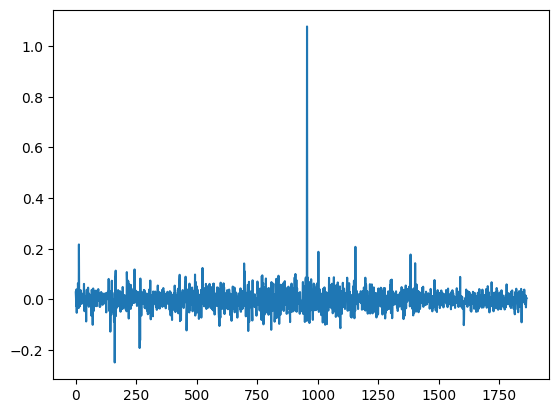

In [19]:
plt.plot(returns)

In [32]:
def bocd(data, model, hazard):
  
    #  Initialize lower triangular matrix representing the posterior as
    #   function of time. Model parameters are initialized in the model class.
    
    log_R       = -np.inf * np.ones((T+1, T+1))
    log_R[0, 0] = 0              # log 0 == 1
    pa       = np.empty(T)  
    pb        = np.empty(T)    
    log_message = np.array([0]) 
    log_H       = np.log(hazard)
    log_1mH     = np.log(1 - hazard)

    for t in range(1, T+1):
        #  Observe new datum.
        x = data[t-1]

        # model predictions
        pa[t-1] = np.sum(np.exp(log_R[t-1, :t]) * model.a_params[:t])
        pb[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * model.b_params[:t])
        
       
        log_pis = model.log_pred_prob(t, x)
        log_growth_probs = log_pis + log_message + log_1mH
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        Update sufficient statistics.
        model.update_params(t, x)

        log_message = new_log_joint

    R = np.exp(log_R)
    
    return R, pa, pb

In [79]:

def plot_posterior(T, data, cps, R, pa, pb):
    fig, axes = plt.subplots(2, 1, figsize=(20,10))

    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)

    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
    ax2.set_xlim([0, T])
    ax2.margins(0)

    plt.tight_layout()
    plt.show()

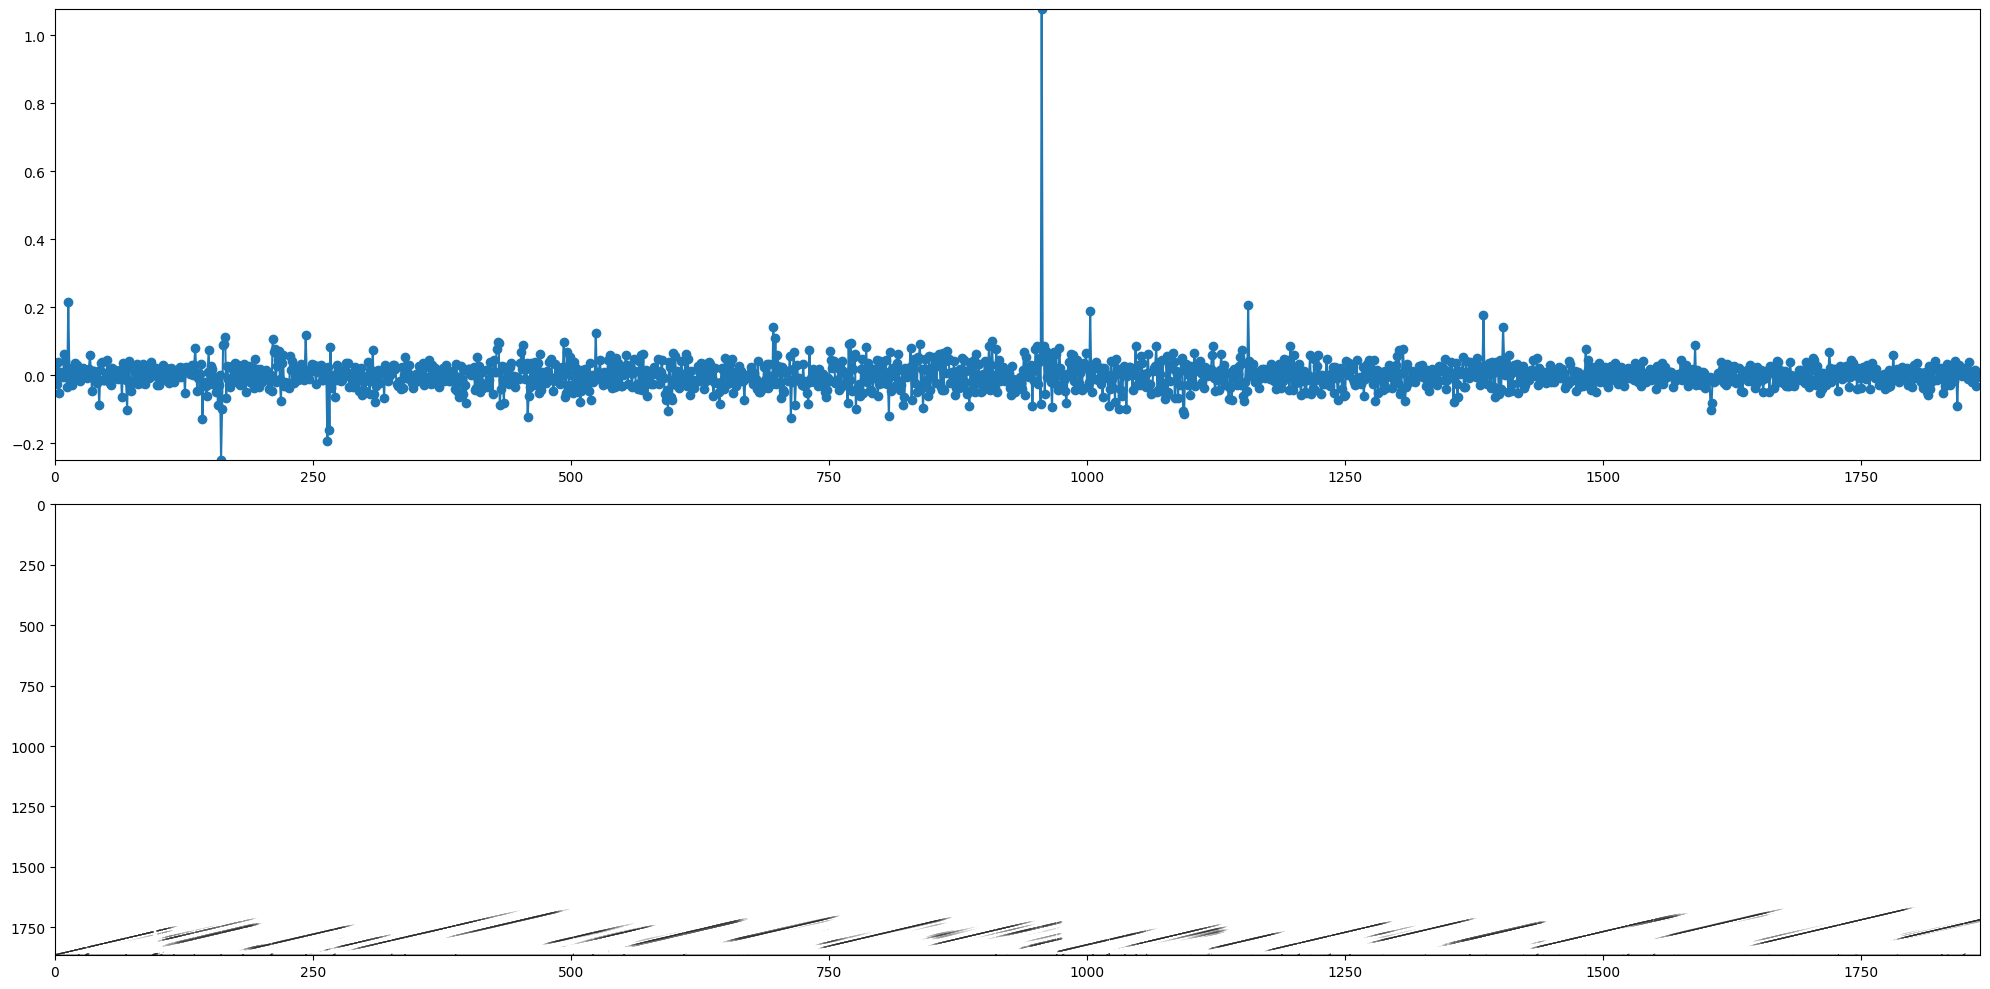

In [80]:

T      = 1865   # Number of observations.
hazard = 1/100  
a0  = 1     
b0   = 10 ** (-4)      # They are suggested by the original paper
   

data, cps      = returns,[i for i in range(1865)]
model          = GaussianUnknownVar(a0, b0)
R, pa, pb = bocd(data, model, hazard)

plot_posterior(T, data, cps, R, pa, pb)
